In [376]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [377]:
import os
from dotenv import load_dotenv

Запросы к API 2 шаг проекта

In [378]:
# Загружаем
load_dotenv()

# Значения
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

# Проверка значений
print(API_URL, DATE_BEGIN, DATE_END)

https://data-charts-api.hexlet.app 2023-03-01 2023-09-01


In [379]:
# Данные о посещениях
visits_url = f'{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}'
visits_response = requests.get(visits_url)
visits_data = visits_response.json()

# Данные о регистрациях
registrations_url = f'{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}'
registrations_response = requests.get(registrations_url)
registrations_data = registrations_response.json()

# Преобразуем в DataFrame
visits_df = pd.DataFrame(visits_data)
registrations_df = pd.DataFrame(registrations_data)

print(visits_df.head())
print(registrations_df.head())

                               visit_id platform  \
0  1de9ea66-70d3-4a1f-8735-df5ef7697fb9      web   
1  f149f542-e935-4870-9734-6b4501eaf614      web   
2  08f0ebd4-950c-4dd9-8e97-b5bdf073eed1      web   
3  19322fed-157c-49c6-b16e-2d5cabeb9592      web   
4  04762a22-3c9f-40c9-9ac9-6628c4381836      web   

                                          user_agent             datetime  
0  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T10:36:22  
1  Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...  2023-03-01T06:25:00  
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...  2023-03-01T10:26:13  
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...  2023-03-01T12:33:06  
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T01:38:35  
              datetime                               user_id  \
0  2023-03-01T07:40:13  2e0f6bb8-b029-4f45-a786-2b53990d37f1   
1  2023-03-01T13:14:00  f007f97c-9d8b-48b5-af08-119bb8f6d9b6   
2  2023-03-01T03:05:50  24ff46ae-32b3-4

In [380]:
# Предварительный анализ данных
print(visits_df.describe())
print(registrations_df.describe())

                                    visit_id platform  \
count                                 263459   263459   
unique                                146085        4   
top     64167edd-323a-4ab0-be9b-acd237a1ac30      web   
freq                                       4   236301   

                                               user_agent             datetime  
count                                              263459               263459  
unique                                                 32               261204  
top     Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...  2023-07-06T10:45:50  
freq                                                13623                    3  
                   datetime                               user_id  \
count                 21836                                 21836   
unique                21821                                 21836   
top     2023-06-23T13:10:45  2e0f6bb8-b029-4f45-a786-2b53990d37f1   
freq                      2      

Расчет метрик 3 Шаг проекта

In [381]:
# Данные о визитах
visits_url = f'{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}'
visits_response = requests.get(visits_url)
visits_data = visits_response.json()

# Данные о регистрациях
registrations_url = f'{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}'
registrations_response = requests.get(registrations_url)
registrations_data = registrations_response.json()

In [382]:
visits_df = pd.DataFrame(visits_data)
registrations_df = pd.DataFrame(registrations_data)

In [383]:
# Удаление ботов
visits_df = visits_df[~visits_df['user_agent'].str.contains('bot')]

# Преобразование datetime
visits_df['date'] = pd.to_datetime(visits_df['datetime']).dt.date

# Оставляем последний визит
visits_df = visits_df.sort_values('date').drop_duplicates('visit_id', keep='last')

In [384]:
# Группировка по дате и платформе
visits_grouped = visits_df.groupby(['date', 'platform']).size().reset_index(name='visits')

In [385]:
# Преобразование даты регистраций
registrations_df['date'] = pd.to_datetime(registrations_df['datetime']).dt.date

In [386]:
# Группировка по дате и платформе
registrations_grouped = registrations_df.groupby(['date', 'platform']).size().reset_index(name='registrations')

In [387]:
# Объединение датафреймов
df = pd.merge(visits_grouped, registrations_grouped, on=['date', 'platform'], how='outer').fillna(0)

In [388]:
# Расчет конверсии
df['conversion'] = (df['registrations'] / df['visits']) * 100

In [389]:
# Переименование столбца
df = df.rename(columns={'date': 'date_group'})

In [390]:
# Сохранение в формате JSON
df.to_json('./conversion.json')

In [391]:
print(df)

     date_group platform  visits  registrations  conversion
0    2023-03-01  android      75             61   81.333333
1    2023-03-01      ios      22             18   81.818182
2    2023-03-01      web     279              8    2.867384
3    2023-03-02  android      67             59   88.059701
4    2023-03-02      ios      31             24   77.419355
..          ...      ...     ...            ...         ...
547  2023-08-30      ios      66             40   60.606061
548  2023-08-30      web    1227             34    2.770986
549  2023-08-31  android      57             42   73.684211
550  2023-08-31      ios      50             36   72.000000
551  2023-08-31      web     721             46    6.380028

[552 rows x 5 columns]


Добавляем рекламы 4 шаг проекта

In [392]:
# Загрузка данных
conversions_df = pd.read_json('./conversion.json')
ads_df = pd.read_csv('./ads.csv')

In [393]:
conversions_df['date_group']= pd.to_datetime(conversions_df['date_group'], unit = 'ms')

In [394]:
ads_df['date'] = pd.to_datetime(ads_df['date'])

In [395]:
# Приведение к формату date без времени
conversions_df['date_group'] = conversions_df['date_group'].dt.date
ads_df['date'] = ads_df['date'].dt.date

In [396]:
ads_df = ads_df.rename(columns={'date': 'date_group'})

In [397]:
# Объединение дф по столбцу date_group
merged_df = pd.merge(conversions_df, ads_df, on='date_group', how='left')

In [398]:
merged_df = merged_df.groupby('date_group').agg({
    'visits': 'sum',
    'registrations': 'sum',
    'cost': 'sum',
    'utm_campaign': 'first'
}).reset_index()

In [399]:
# Заполнение пропусков
merged_df['cost'] = merged_df['cost'].fillna(0)
merged_df['utm_campaign'] = merged_df['utm_campaign'].fillna('none')

In [400]:
# Только нужные поля
final_df = merged_df[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

In [401]:
# Сохранение дф в формате json
final_df.to_json('./ads.json')

In [402]:
print(final_df)

     date_group  visits  registrations   cost                utm_campaign
0    2023-03-01     376             87  636.0  advanced_algorithms_series
1    2023-03-02     613            106  756.0  advanced_algorithms_series
2    2023-03-03     683            107  606.0  advanced_algorithms_series
3    2023-03-04     647            159  669.0  advanced_algorithms_series
4    2023-03-05     707            115  795.0  advanced_algorithms_series
..          ...     ...            ...    ...                         ...
179  2023-08-27     795             88  666.0      intro_to_python_course
180  2023-08-28     635             83  669.0      intro_to_python_course
181  2023-08-29    1268            143  570.0      intro_to_python_course
182  2023-08-30    1328            101  327.0      intro_to_python_course
183  2023-08-31     828            124  645.0      intro_to_python_course

[184 rows x 5 columns]


Визуализация 5 шаг проекта

In [403]:
# Загрузка данных
final_df = pd.read_json('./ads.json')
conversion_df = pd.read_json('./conversion.json')

In [404]:
final_df['date_group']=pd.to_datetime(final_df['date_group'],unit = 'ms')
conversion_df['date_group']=pd.to_datetime(conversion_df['date_group'],unit = 'ms')

In [405]:
#Директория charts
if not os.path.exists('./charts'):
    os.makedirs('./charts')

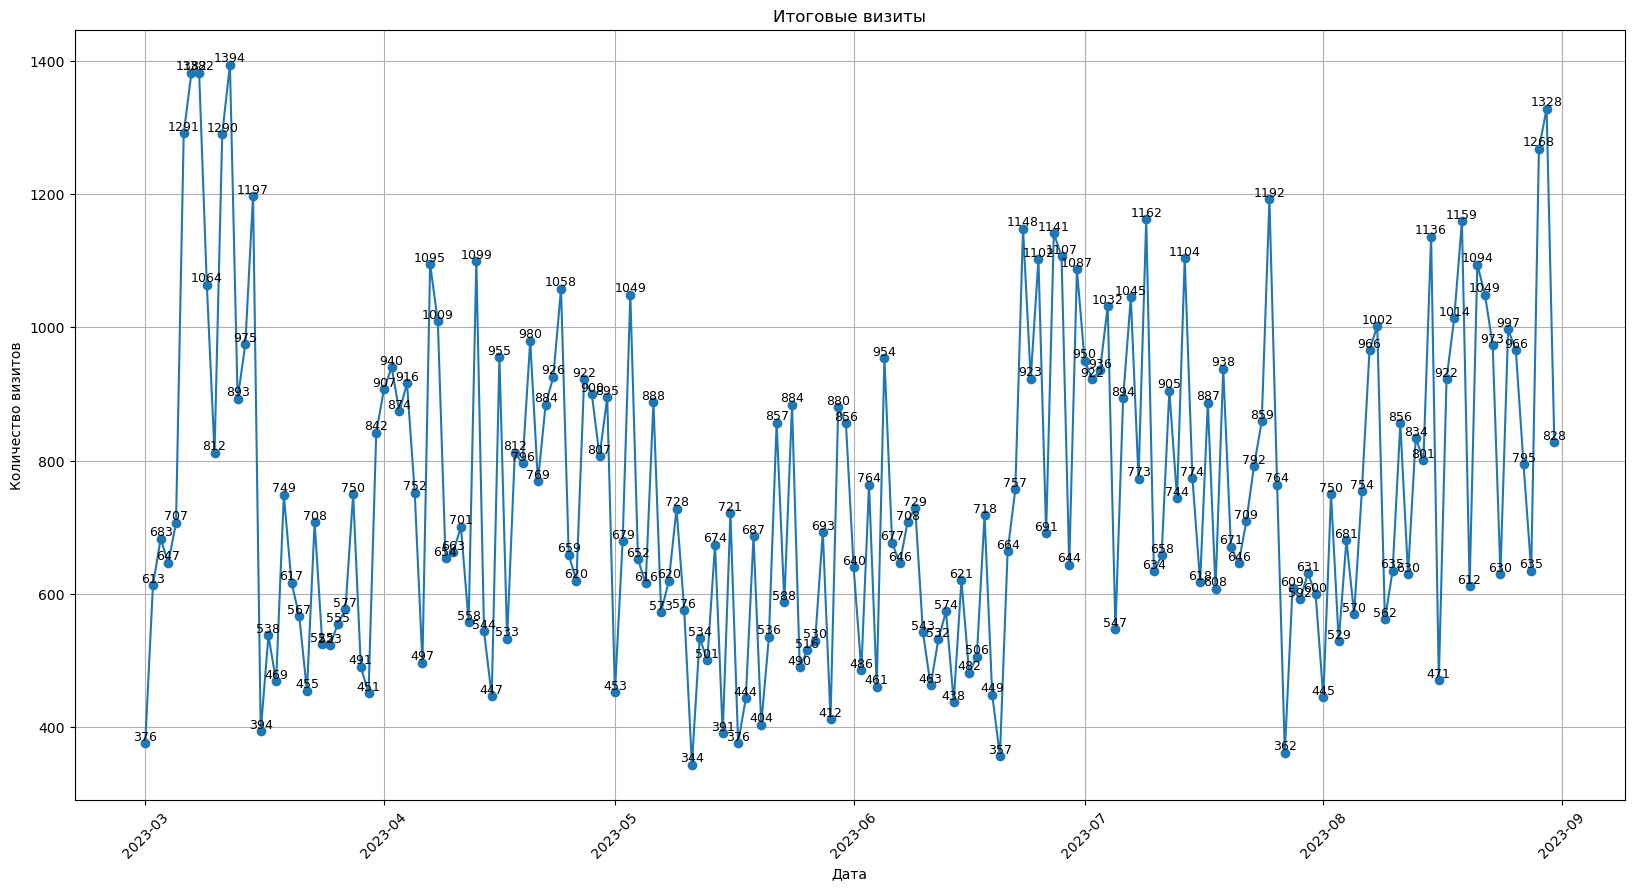

In [406]:
#Итоговые визиты
plt.figure(figsize=(20,10))
plt.plot(final_df['date_group'], final_df['visits'], marker='o')
plt.title('Итоговые визиты')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.grid()
plt.xticks(rotation=45)
for i, value in enumerate(final_df['visits']):
    plt.text(final_df['date_group'][i], value, str(value), fontsize=9, ha='center', va='bottom')
plt.savefig('./charts/chart1.png')
plt.show()

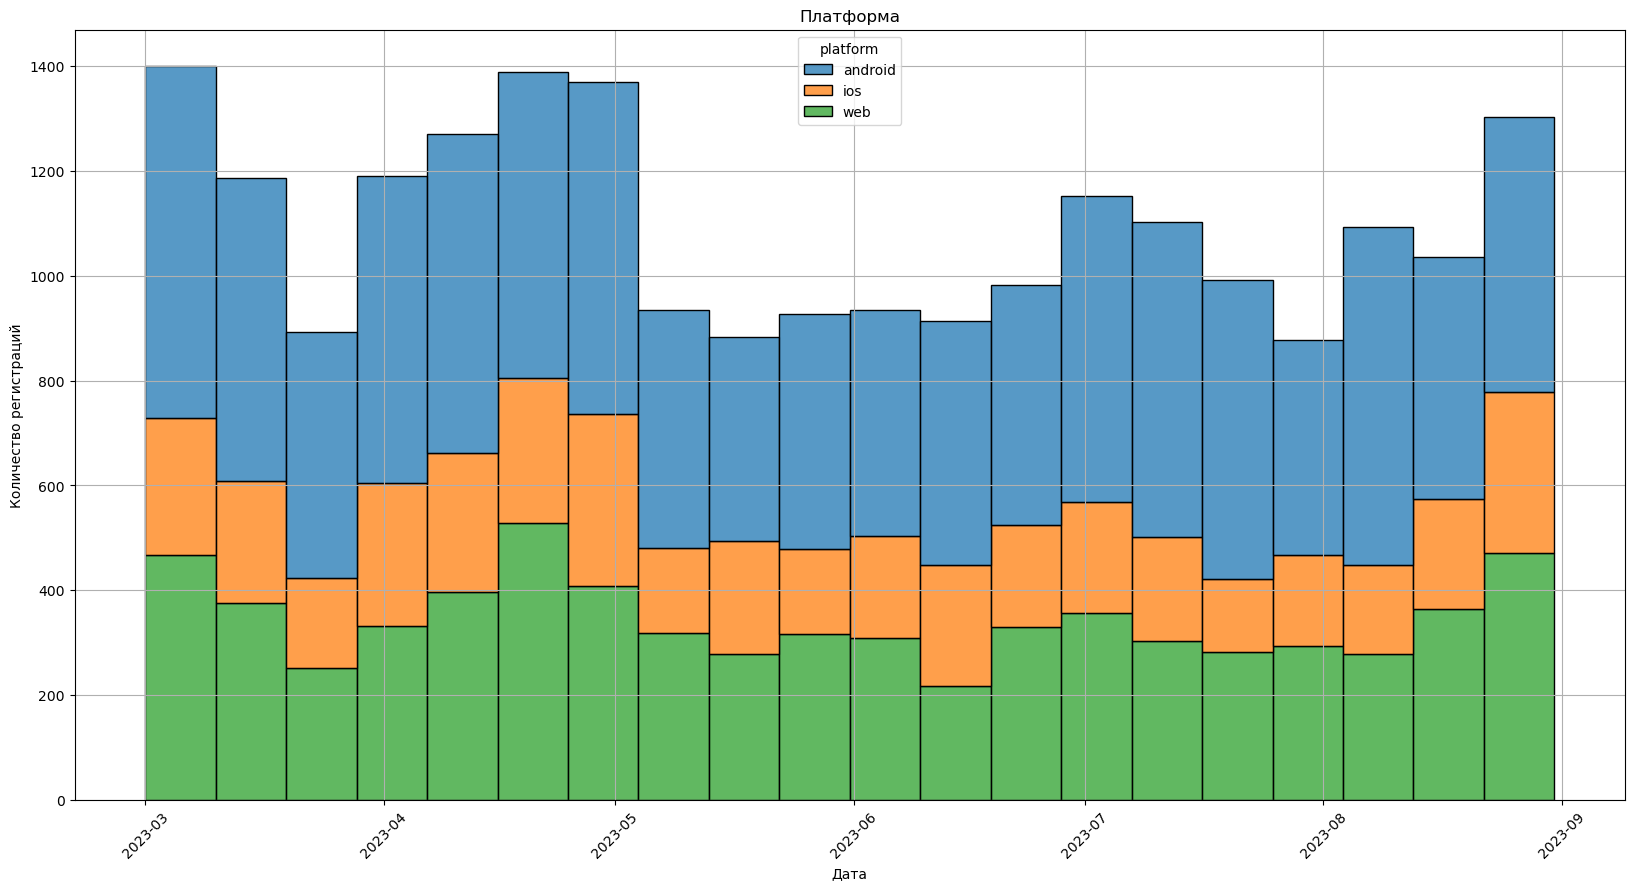

In [407]:
#Итоговые визиты с разбивкой по платформам: web, android, ios
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='date_group', weights='registrations', hue='platform', data=conversion_df, multiple='stack', bins=20)
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.title('Платформа')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('./charts/chart2.png')
plt.show()

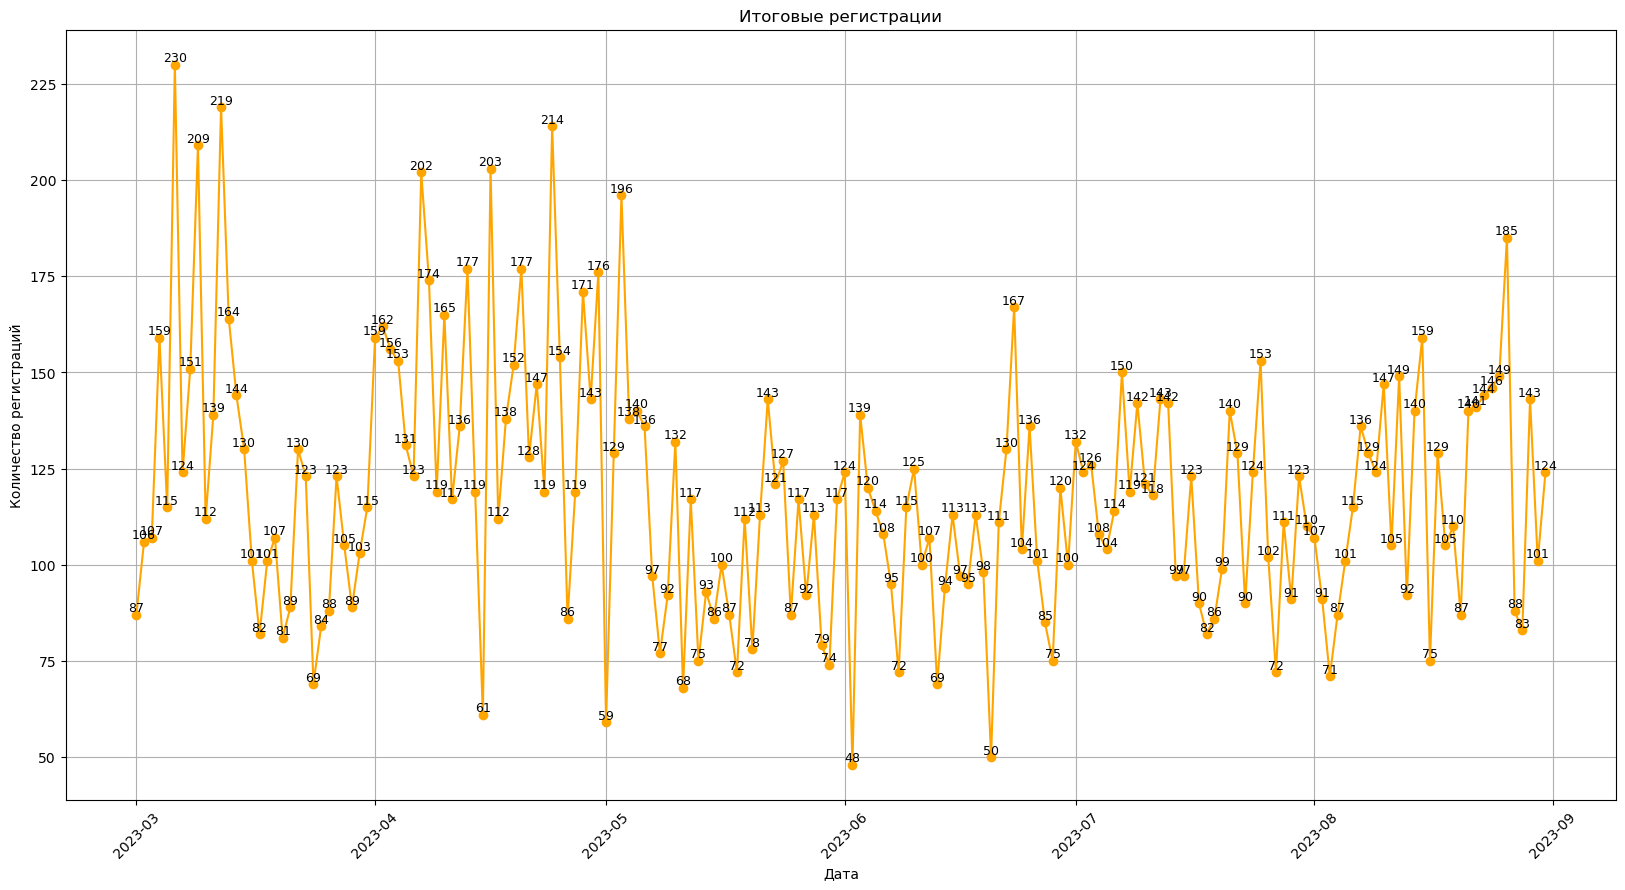

In [408]:
#Итоговые регистрации
plt.figure(figsize=(20, 10))
plt.plot(final_df['date_group'], final_df['registrations'], marker='o', color='orange')
plt.title('Итоговые регистрации')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.xticks(rotation=45)
plt.grid()
for i, value in enumerate(final_df['registrations']):
    plt.text(final_df['date_group'][i], value, str(value), fontsize=9, ha='center', va='bottom')
plt.savefig('./charts/chart3.png')
plt.show()

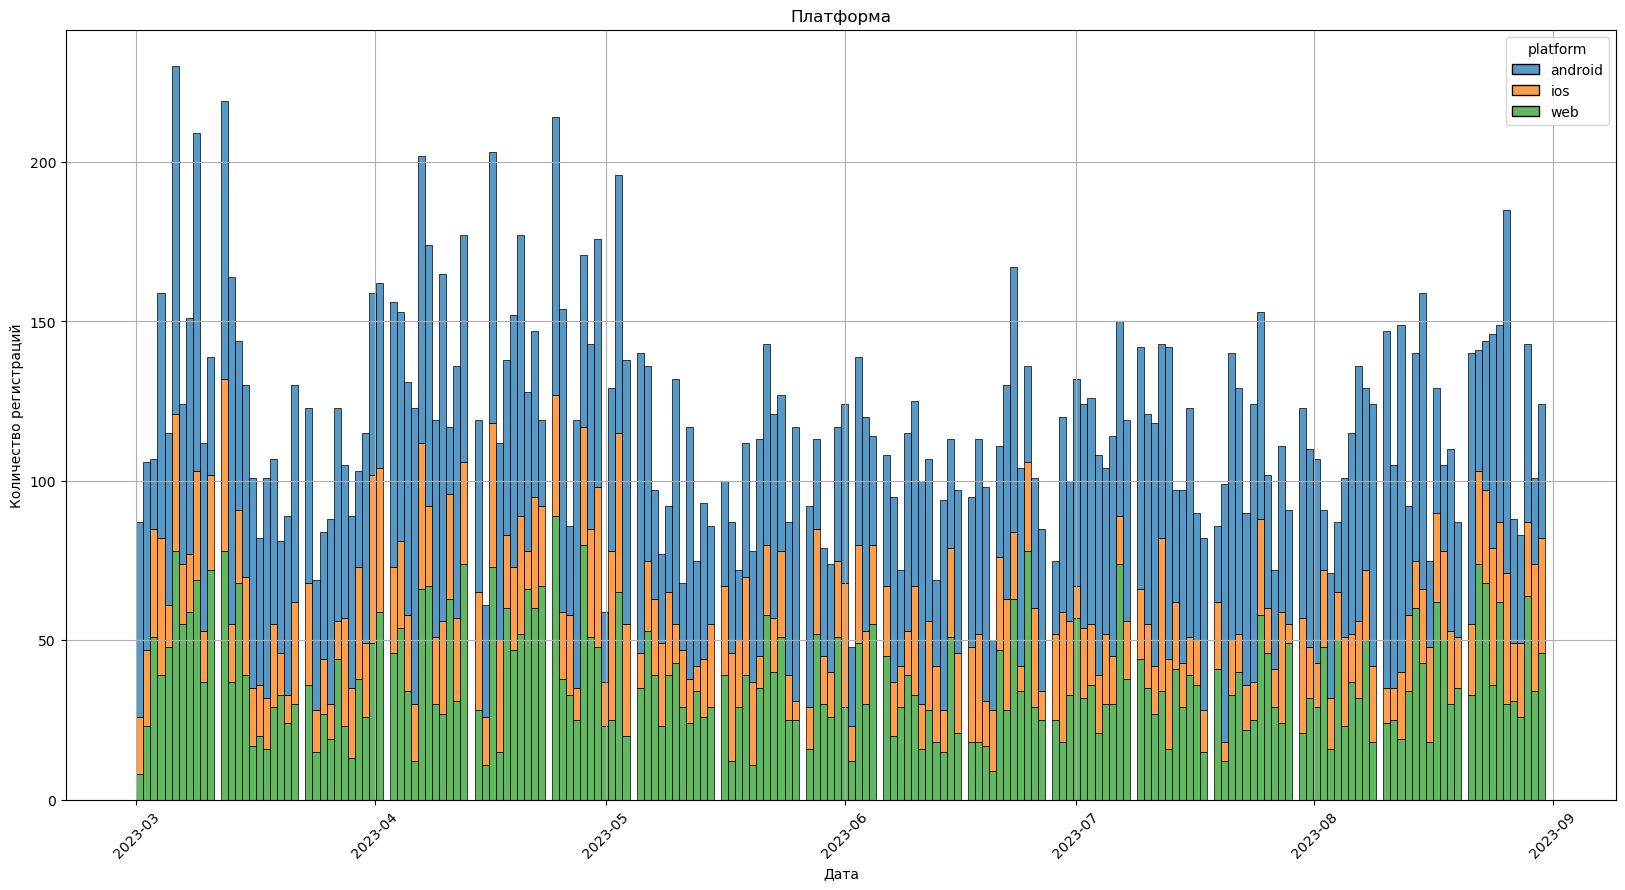

In [409]:
#Итоговые регистрации с разбивкой по платформе: web, android, ios
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='date_group', weights='registrations', hue = 'platform', data=conversion_df, multiple='stack', bins=200)
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.title('Платформа')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('./charts/chart4.png')
plt.show()

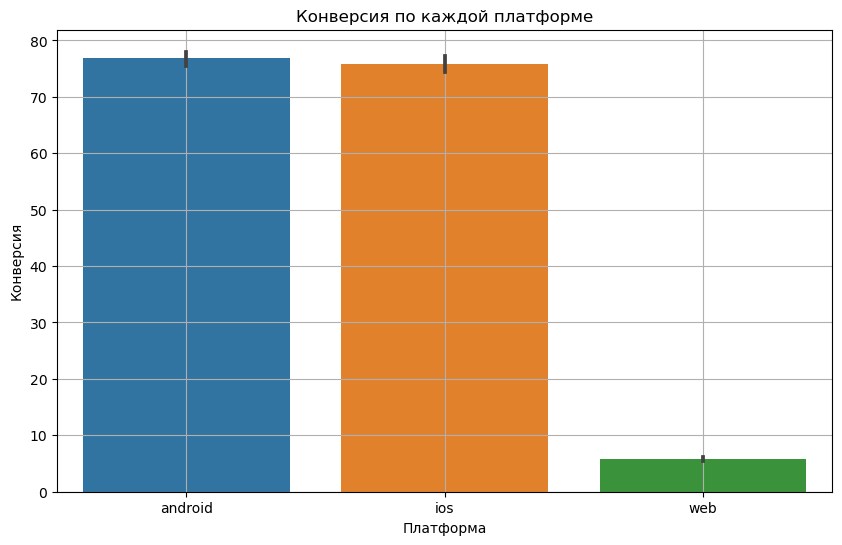

In [410]:
#Конверсия по каждой платформе
conversion_df['conversion'] = (conversion_df['registrations'] / conversion_df['visits']) * 100
plt.figure(figsize =(10,6))
sns.barplot(data = conversion_df, x = 'platform', y = 'conversion')
plt.xlabel('Платформа')
plt.ylabel('Конверсия')
plt.title('Конверсия по каждой платформе')
plt.grid()
plt.savefig('./charts/chart5.png')
plt.show()

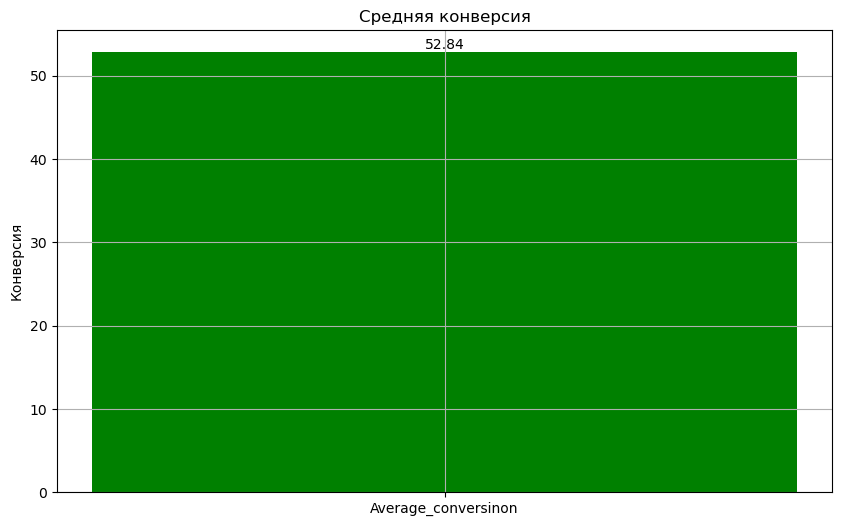

In [411]:
#Средняя конверсия
average_conversinon = conversion_df['conversion'].mean()
plt.figure(figsize=(10,6))
plt.bar(['Average_conversinon'], [average_conversinon], color = 'green')
plt.text(0, average_conversinon + 0.01, f'{average_conversinon:.2f}', ha='center', va='bottom')
plt.title('Средняя конверсия')
plt.ylabel('Конверсия')
plt.grid()
plt.savefig('./charts/chart6.png')
plt.show()

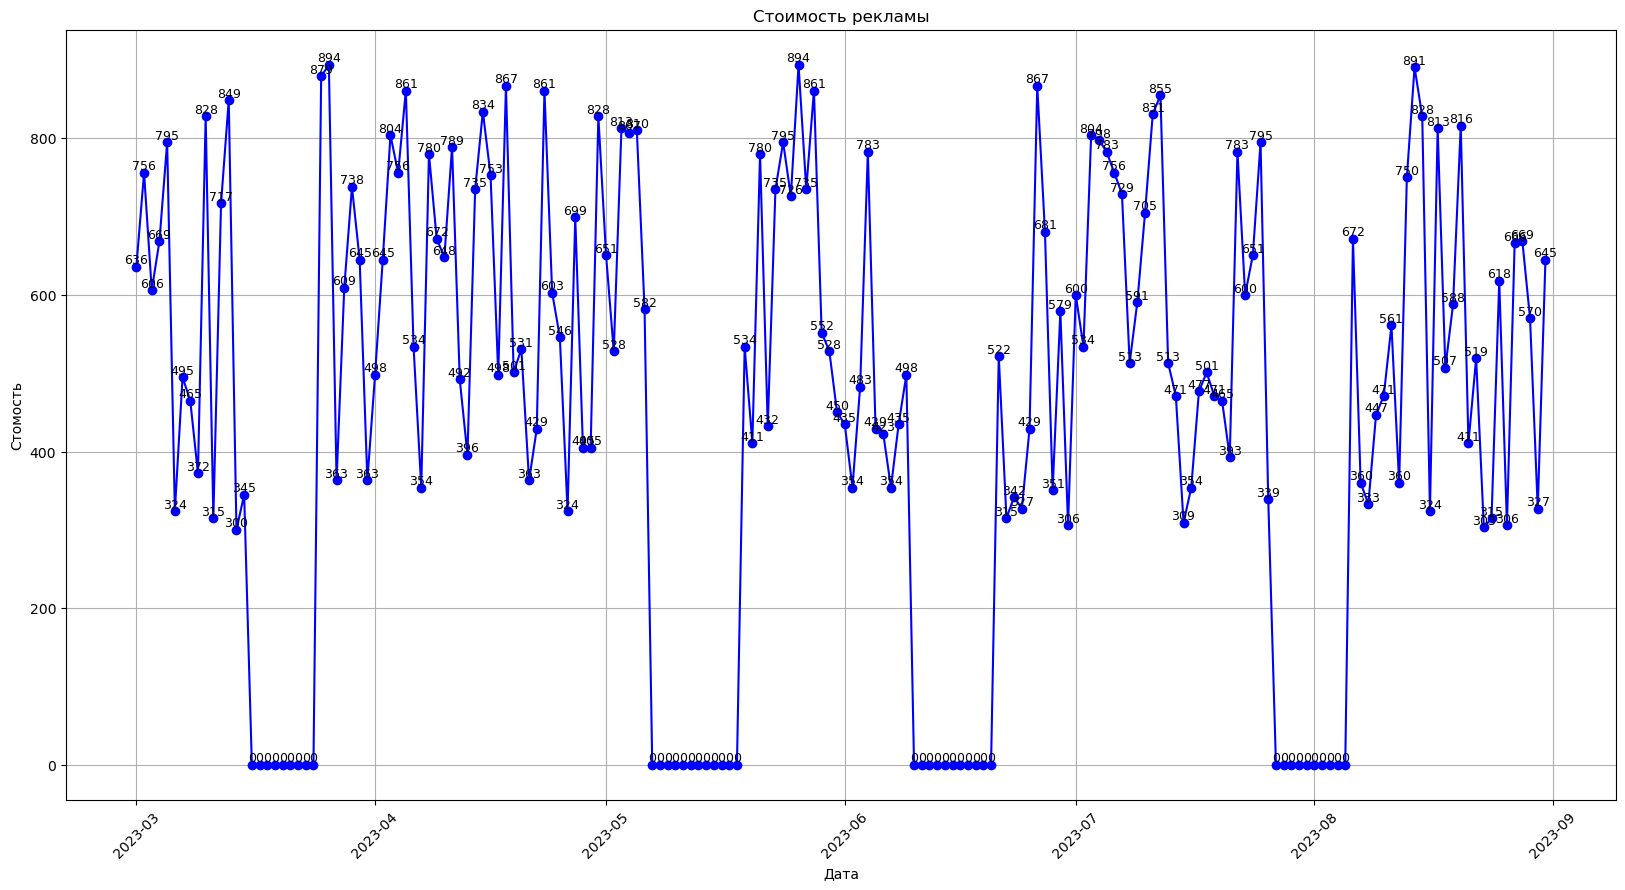

In [412]:
#Стоимость рекламы
plt.figure(figsize=(20, 10))
plt.plot(final_df['date_group'], final_df['cost'], marker='o', color='blue')
plt.title('Стоимость рекламы')
plt.xlabel('Дата')
plt.ylabel('Стомость')
plt.xticks(rotation=45)
plt.grid()
for i, value in enumerate(final_df['cost']):
    plt.text(final_df['date_group'][i], value, str(value), fontsize=9, ha='center', va='bottom')
plt.savefig('./charts/chart7.png')
plt.show()

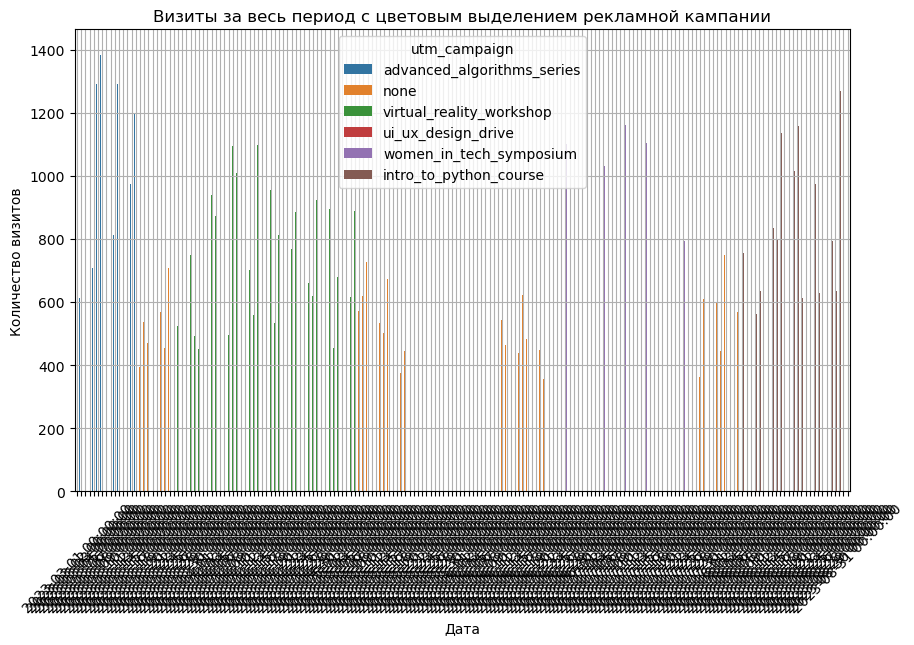

In [413]:
#Визиты за весь период с цветовым выделением рекламной кампании
plt.figure(figsize=(10,6))
sns.barplot(data = final_df, x = 'date_group', y = 'visits', hue = 'utm_campaign')
plt.title('Визиты за весь период с цветовым выделением рекламной кампании')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('./charts/chart8.png')
plt.show()

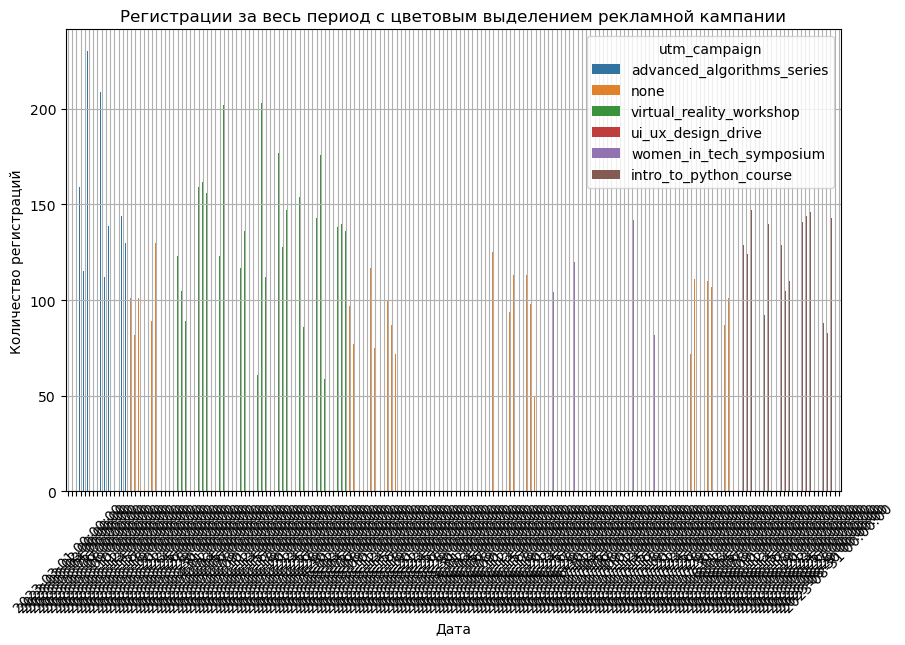

In [414]:
#Регистрации за весь период с цветовым выделением рекламной кампании
plt.figure(figsize=(10,6))
sns.barplot(data = final_df, x = 'date_group', y = 'registrations', hue = 'utm_campaign')
plt.title('Регистрации за весь период с цветовым выделением рекламной кампании')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('./charts/chart9.png')
plt.show()